# Analysis of Expected SARSA for RL-Based SPamCo Paper
___

###Notes
* Q-learning as an off-policy algorithm is probably the baseline algorithm to use. However, consider the following: If our confidence is low and we are just starting out training for SPamCo, we can effectively consider labels as being selected at random, and thus alluding to the expected performance of SARSA. We may not be too greedy with the reward here. However, as our confidence grows, we may get more greedy and evolve into Q-learning. Expected SARSA will allow us to take advantage of both worlds such that we can start out in ~SARSA and evolve into ~Q-learning.

* Expected SARSA is more computationally expensive since we are calculating the expected reward at each update state. However, it is more accurate since it eliminates the variance due to random selection of the next action. Since our whole goal is to try to find expected rewards for unobservable states, I think the increase in computational complexity is justified. Need to have some remarks around this.

* On policies:
  * Off-policy methods can learn the optimal policy regardless of the behaviour policy (actually the behaviour policy should have some properties), while on-policy methods require the agent acts with the policy that it's being learnt.

  * Imagine the situation where you have a data set of trajectories (i.e, data in form of tuples (s,a,r,s')) previously stored. This data has been collected applying a given policy, and you cannot change it. In this case, which is common for medical problems, you can apply only off-policy methods.

  * This means that off-policy methods are better? No necessarily. We can say that off-policy methods are more flexible in the type of problems they can face. However, from the theoretical point of view, they have different properties that sometimes are convenient. For instance, if we compare Q-learning versus SARSA algorithm, a key difference between them is the max operator used in the Q-learning update rule. This operator is highly non-linear, which can make more difficult to combine the algorithm with function approximators.

  * When it's better to use on-policy methods? Well, if you are facing a problem with continuous state-space and you are interested in using a linear function approximator (and RFB network, for instance). Then it's more stable to use on-policy methods. You can find more information on this topic in the Section off-policy bootstrapping of Sutton and Barto's book.

____
* SARSA and Q-Learning technique in Reinforcement Learning are algorithms that uses Temporal Difference(TD) Update to improve the agent’s behaviour. Expected SARSA technique is an alternative for improving the agent’s policy. It is very similar to SARSA and Q-Learning, and differs in the action value function it follows. 
We know that SARSA is an on-policy technique, Q-learning is an off-policy technique, but Expected SARSA can be use either as an on-policy or off-policy. This is where Expected SARSA is much more flexible compared to both these algorithms.
Let’s compare the action-value function of all the three algorithms and find out what is different in Expected SARSA. 

* We see that Expected SARSA takes the weighted sum of all possible next actions with respect to the probability of taking that action. If the Expected Return is greedy with respect to the expected return, then this equation gets transformed to Q-Learning. Otherwise Expected SARSA is on-policy and computes the expected return for all actions, rather than randomly selecting an action like SARSA.
Keeping the theory and the formulae in mind, let us compare all the three algorithms, with an experiment. We shall implement a Cliff Walker as our environment provided by the gym library.

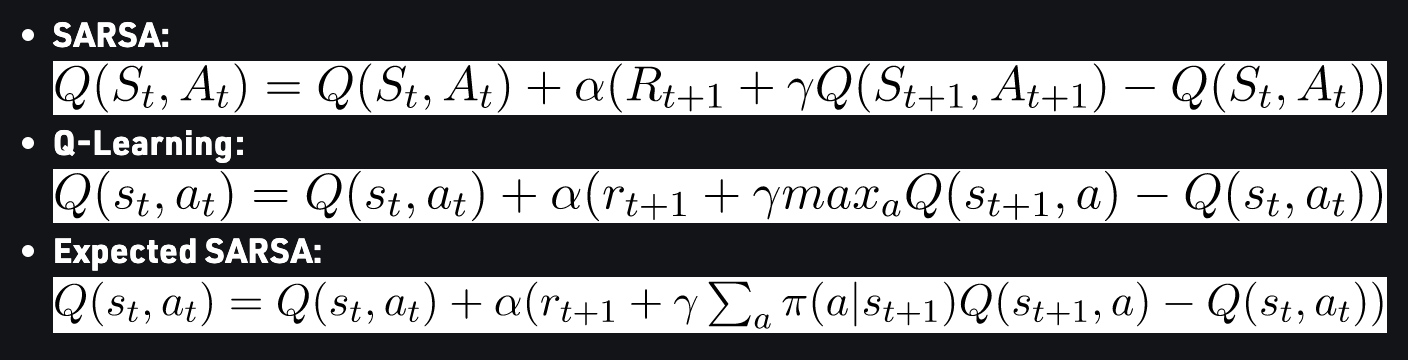

# Greediness

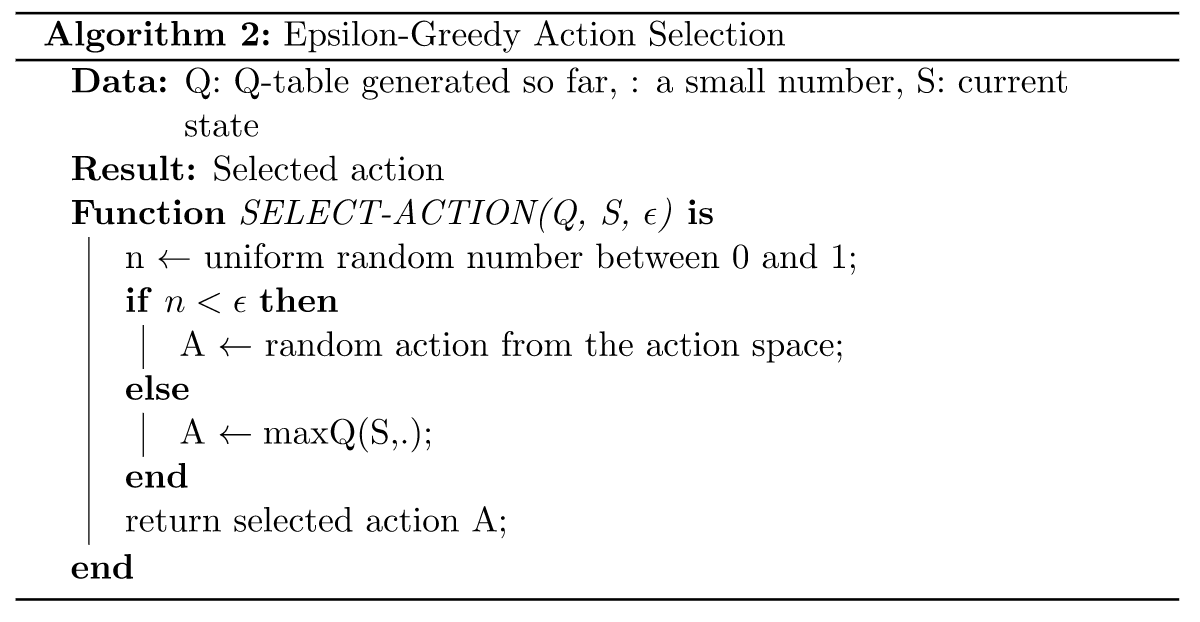

### References:
* https://www.geeksforgeeks.org/expected-sarsa-in-reinforcement-learning/
* https://stackoverflow.com/questions/42606589/are-off-policy-learning-methods-better-than-on-policy-methods

In [1]:
import numpy as np
import gym
from matplotlib import pyplot as plt

### Agent Class

In [2]:
# Agent.py

class Agent:
	"""
	The Base class that is implemented by
	other classes to avoid the duplicate 'choose_action'
	method
	"""
	def choose_action(self, state):
		action = 0
		if np.random.uniform(0, 1) < self.epsilon:
			action = self.action_space.sample()
		else:
			action = np.argmax(self.Q[state, :])
		return action


### SARSA

In [3]:
# SarsaAgent.py

class SarsaAgent(Agent):
	"""
	The Agent that uses SARSA update to improve it's behaviour
	"""
	def __init__(self, epsilon, alpha, gamma, num_state, num_actions, action_space):
		"""
		Constructor
		Args:
			epsilon: The degree of exploration
			gamma: The discount factor
			num_state: The number of states
			num_actions: The number of actions
			action_space: To call the random action
		"""
		self.epsilon = epsilon
		self.alpha = alpha
		self.gamma = gamma
		self.num_state = num_state
		self.num_actions = num_actions

		self.Q = np.zeros((self.num_state, self.num_actions))
		self.action_space = action_space


	def update(self, prev_state, next_state, reward, prev_action, next_action):
		"""
		Update the action value function using the SARSA update.
		Q(S, A) = Q(S, A) + alpha(reward + (gamma * Q(S_, A_) - Q(S, A))
		Args:
			prev_state: The previous state
			next_state: The next state
			reward: The reward for taking the respective action
			prev_action: The previous action
			next_action: The next action
		Returns:
			None
		"""
		predict = self.Q[prev_state, prev_action]
		target = reward + self.gamma * self.Q[next_state, next_action]
		self.Q[prev_state, prev_action] += self.alpha * (target - predict)


### Q-Learning

In [4]:
# QLearningAgent.py

class QLearningAgent(Agent):
	def __init__(self, epsilon, alpha, gamma, num_state, num_actions, action_space):
		"""
		Constructor
		Args:
			epsilon: The degree of exploration
			gamma: The discount factor
			num_state: The number of states
			num_actions: The number of actions
			action_space: To call the max reward action
		"""
		self.epsilon = epsilon
		self.alpha = alpha
		self.gamma = gamma
		self.num_state = num_state
		self.num_actions = num_actions

		self.Q = np.zeros((self.num_state, self.num_actions))
		self.action_space = action_space


	def update(self, state, state2, reward, action, action2):
		"""
		Update the action value function using the Q-Learning update.
		Q(S, A) = Q(S, A) + alpha(reward + (gamma * Q(S_, A_) - Q(S, A))
		Args:
			prev_state: The previous state
			next_state: The next state
			reward: The reward for taking the respective action
			prev_action: The previous action
			next_action: The next action
		Returns:
			None
		"""
		predict = self.Q[state, action]
		target = reward + self.gamma * np.max(self.Q[state2, :])
		self.Q[state, action] += self.alpha * (target - predict)


### Expected SARSA

In [5]:
# ExpectedSarsaAgent.py

class ExpectedSarsaAgent(Agent):
	def __init__(self, epsilon, alpha, gamma, num_state, num_actions, action_space):
		"""
		Constructor
		Args:
			epsilon: The degree of exploration
			gamma: The discount factor
			num_state: The number of states
			num_actions: The number of actions
			action_space: To call the expected action
		"""
		self.epsilon = epsilon
		self.alpha = alpha
		self.gamma = gamma
		self.num_state = num_state
		self.num_actions = num_actions

		self.Q = np.zeros((self.num_state, self.num_actions))
		self.action_space = action_space


	def update(self, prev_state, next_state, reward, prev_action, next_action):
		"""
		Update the action value function using the Expected SARSA update.
		Q(S, A) = Q(S, A) + alpha(reward + (pi * Q(S_, A_) - Q(S, A))
		Args:
			prev_state: The previous state
			next_state: The next state
			reward: The reward for taking the respective action
			prev_action: The previous action
			next_action: The next action
		Returns:
			None
		"""
		predict = self.Q[prev_state, prev_action]

		expected_q = 0
		q_max = np.max(self.Q[next_state, :])
		greedy_actions = 0
		for i in range(self.num_actions):
			if self.Q[next_state][i] == q_max:
				greedy_actions += 1
	
		non_greedy_action_probability = self.epsilon / self.num_actions
		greedy_action_probability = ((1 - self.epsilon) / greedy_actions) + non_greedy_action_probability

		for i in range(self.num_actions):
			if self.Q[next_state][i] == q_max:
				expected_q += self.Q[next_state][i] * greedy_action_probability
			else:
				expected_q += self.Q[next_state][i] * non_greedy_action_probability

		target = reward + self.gamma * expected_q
		self.Q[prev_state, prev_action] += self.alpha * (target - predict)

# Environment
### Cliffwalking

*https://github.com/caburu/gym-cliffwalking*

In [6]:
# main.py

# Using the gym library to create the environment
env = gym.make('CliffWalking-v0')

# Defining all the required parameters
epsilon = 0.1
total_episodes = 500
max_steps = 100
alpha = 0.5
gamma = 1
"""
	The two parameters below is used to calculate
	the reward by each algorithm
"""
episodeReward = 0
totalReward = {
	'SarsaAgent': [],
	'QLearningAgent': [],
	'ExpectedSarsaAgent': []
}

# Defining all the three agents
expectedSarsaAgent = ExpectedSarsaAgent(
	epsilon, alpha, gamma, env.observation_space.n,
	env.action_space.n, env.action_space)
qLearningAgent = QLearningAgent(
	epsilon, alpha, gamma, env.observation_space.n,
	env.action_space.n, env.action_space)
sarsaAgent = SarsaAgent(
	epsilon, alpha, gamma, env.observation_space.n,
	env.action_space.n, env.action_space)

# Now we run all the episodes and calculate the reward obtained by
# each agent at the end of the episode

agents = [expectedSarsaAgent, qLearningAgent, sarsaAgent]
trajectories = []
for agent in agents:
	trajectory = []
	for episode in range(total_episodes):
		# Initialize the necessary parameters before
		# the start of the episode
		t = 0
		state1 = env.reset()
		action1 = agent.choose_action(state1)
		episodeReward = 0
		while t < max_steps:

			# Getting the next state, reward, and other parameters
			state2, reward, done, info = env.step(action1)
	
			# Choosing the next action
			action2 = agent.choose_action(state2)
			
			# Learning the Q-value
			agent.update(state1, state2, reward, action1, action2)
			trajectory.append([state1, state2, reward, action1, action2])
   			# print(f'episode: {episode}\n\tstate: {state1}\taction: {action2}\treward: {reward}\tnew state: {state2}\ttarget: {target}')

			state1 = state2
			action1 = action2
			
			# Updating the respective vaLues
			t += 1
			episodeReward += reward
			
			# If at the end of learning process
			if done:
				break
		# Append the sum of reward at the end of the episode
		totalReward[type(agent).__name__].append(episodeReward)
	trajectories.append(trajectory)
env.close()

# Calculate the mean of sum of returns for each episode
meanReturn = {
	'SARSA-Agent': np.mean(totalReward['SarsaAgent']),
	'Q-Learning-Agent': np.mean(totalReward['QLearningAgent']),
	'Expected-SARSA-Agent': np.mean(totalReward['ExpectedSarsaAgent'])
}

# Print the results
print(f"SARSA Average Sum of Reward: {meanReturn['SARSA-Agent']}")
print(f"Q-Learning Average Sum of Return: {meanReturn['Q-Learning-Agent']}")
print(f"Expected Sarsa Average Sum of Return: {meanReturn['Expected-SARSA-Agent']}")
print(trajectories)
print(agents[0].Q.tolist())
print(f"optimal policy: {[np.argmax(row) for row in agents[0].Q.tolist()]}")

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


SARSA Average Sum of Reward: -34.38
Q-Learning Average Sum of Return: -60.546
Expected Sarsa Average Sum of Return: -28.704
[[[36, 24, -1, 0, 0], [24, 12, -1, 0, 0], [12, 0, -1, 0, 0], [0, 0, -1, 0, 0], [0, 0, -1, 0, 1], [0, 1, -1, 1, 0], [1, 1, -1, 0, 0], [1, 1, -1, 0, 1], [1, 2, -1, 1, 0], [2, 2, -1, 0, 0], [2, 2, -1, 0, 1], [2, 3, -1, 1, 2], [3, 15, -1, 2, 0], [15, 3, -1, 0, 0], [3, 3, -1, 0, 0], [3, 3, -1, 0, 1], [3, 4, -1, 1, 0], [4, 4, -1, 0, 0], [4, 4, -1, 0, 2], [4, 16, -1, 2, 0], [16, 4, -1, 0, 1], [4, 5, -1, 1, 0], [5, 5, -1, 0, 0], [5, 5, -1, 0, 1], [5, 6, -1, 1, 0], [6, 6, -1, 0, 0], [6, 6, -1, 0, 1], [6, 7, -1, 1, 0], [7, 7, -1, 0, 0], [7, 7, -1, 0, 1], [7, 8, -1, 1, 0], [8, 8, -1, 0, 0], [8, 8, -1, 0, 1], [8, 9, -1, 1, 0], [9, 9, -1, 0, 0], [9, 9, -1, 0, 1], [9, 10, -1, 1, 0], [10, 10, -1, 0, 0], [10, 10, -1, 0, 1], [10, 11, -1, 1, 0], [11, 11, -1, 0, 0], [11, 11, -1, 0, 1], [11, 11, -1, 1, 1], [11, 11, -1, 1, 2], [11, 23, -1, 2, 0], [23, 11, -1, 0, 3], [11, 10, -1, 3, 3]

In [7]:
def get_state_action_table(q_table):
    table: list = []
    for i in range(len(q_table)):
        for j in range(len(q_table[0])):
            table.append([i, j])
    return table

table = get_state_action_table(agents[0].Q)
print(table)

[[0, 0], [0, 1], [0, 2], [0, 3], [1, 0], [1, 1], [1, 2], [1, 3], [2, 0], [2, 1], [2, 2], [2, 3], [3, 0], [3, 1], [3, 2], [3, 3], [4, 0], [4, 1], [4, 2], [4, 3], [5, 0], [5, 1], [5, 2], [5, 3], [6, 0], [6, 1], [6, 2], [6, 3], [7, 0], [7, 1], [7, 2], [7, 3], [8, 0], [8, 1], [8, 2], [8, 3], [9, 0], [9, 1], [9, 2], [9, 3], [10, 0], [10, 1], [10, 2], [10, 3], [11, 0], [11, 1], [11, 2], [11, 3], [12, 0], [12, 1], [12, 2], [12, 3], [13, 0], [13, 1], [13, 2], [13, 3], [14, 0], [14, 1], [14, 2], [14, 3], [15, 0], [15, 1], [15, 2], [15, 3], [16, 0], [16, 1], [16, 2], [16, 3], [17, 0], [17, 1], [17, 2], [17, 3], [18, 0], [18, 1], [18, 2], [18, 3], [19, 0], [19, 1], [19, 2], [19, 3], [20, 0], [20, 1], [20, 2], [20, 3], [21, 0], [21, 1], [21, 2], [21, 3], [22, 0], [22, 1], [22, 2], [22, 3], [23, 0], [23, 1], [23, 2], [23, 3], [24, 0], [24, 1], [24, 2], [24, 3], [25, 0], [25, 1], [25, 2], [25, 3], [26, 0], [26, 1], [26, 2], [26, 3], [27, 0], [27, 1], [27, 2], [27, 3], [28, 0], [28, 1], [28, 2], [28,

### Grid World / Frozen Lake

In [8]:
# main.py

# Using the gym library to create the environment
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
# env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=True)
# env = gym.make('FrozenLake-v0')   # 8x8
# env = gym.make('FrozenLake-v0', desc=None, map_name="4x4", is_slippery=True)
'''
    4 x 4 map
    S F F F       (S: starting point, safe)
    F H F H       (F: frozen surface, safe)
    F F F H       (H: hole, fall to your doom)
    H F F G       (G: goal, where the frisbee is located)

    8 x 8 map
    "SFFFFFFF"
    "FFFFFFFF"
    "FFFHFFFF"
    "FFFFFHFF"
    "FFFHFFFF"
    "FHHFFFHF"
    "FHFFHFHF"
    "FFFHFFFG"
'''

# Defining all the required parameters
epsilon = 0.5
total_episodes = 500
max_steps = 1000
alpha = 0.8
gamma = 0.95
"""
	The two parameters below is used to calculate
	the reward by each algorithm
"""
episodeReward = 0
totalReward = {
	'SarsaAgent': [],
	'QLearningAgent': [],
	'ExpectedSarsaAgent': []
}

# Defining all the three agents
expectedSarsaAgent = ExpectedSarsaAgent(
	epsilon, alpha, gamma, env.observation_space.n,
	env.action_space.n, env.action_space)
qLearningAgent = QLearningAgent(
	epsilon, alpha, gamma, env.observation_space.n,
	env.action_space.n, env.action_space)
sarsaAgent = SarsaAgent(
	epsilon, alpha, gamma, env.observation_space.n,
	env.action_space.n, env.action_space)

# Now we run all the episodes and calculate the reward obtained by
# each agent at the end of the episode

agents = [expectedSarsaAgent, qLearningAgent, sarsaAgent]

for agent in agents:
	for episode in range(total_episodes):
		# Initialize the necessary parameters before
		# the start of the episode
		t = 0
		state1 = env.reset()
		action1 = agent.choose_action(state1)
		episodeReward = 0
		while t < max_steps:

			# Getting the next state, reward, and other parameters
			state2, reward, done, info = env.step(action1)
	
			# Choosing the next action
			action2 = agent.choose_action(state2)
			
			# Learning the Q-value
			agent.update(state1, state2, reward, action1, action2)
			# print(f'episode: {episode}\n\tstate: {state1}\taction: {action2}\treward: {reward}\tnew state: {state2}\ttarget: {target}')

			state1 = state2
			action1 = action2
			
			# Updating the respective vaLues
			t += 1
			episodeReward += reward
			
			# If at the end of learning process
			if done:
				break
		# Append the sum of reward at the end of the episode
		totalReward[type(agent).__name__].append(episodeReward)
env.close()

# Calculate the mean of sum of returns for each episode
meanReturn = {
	'SARSA-Agent': np.mean(totalReward['SarsaAgent']),
	'Q-Learning-Agent': np.mean(totalReward['QLearningAgent']),
	'Expected-SARSA-Agent': np.mean(totalReward['ExpectedSarsaAgent'])
}

# Print the results
print(f"SARSA Average Sum of Reward: {meanReturn['SARSA-Agent']}")
print(f"Q-Learning Average Sum of Return: {meanReturn['Q-Learning-Agent']}")
print(f"Expected Sarsa Average Sum of Return: {meanReturn['Expected-SARSA-Agent']}")
print(agents[0].Q.tolist())
print(f"optimal policy: {[np.argmax(row) for row in agents[0].Q.tolist()]}")

SARSA Average Sum of Reward: 0.0
Q-Learning Average Sum of Return: 0.0
Expected Sarsa Average Sum of Return: 0.052
[[0.19032667112894672, 0.2307316460385804, 0.1200712989421377, 0.18918727948616076], [0.1952273535893443, 0.0, 0.015181315431088317, 0.059473207411536645], [0.04407740233872563, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.22787956760263292, 0.3145916569381294, 0.0, 0.19360112921180647], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.2995686215213796, 0.0, 0.4318675839925848, 0.22986455744882886], [0.3007455101081199, 0.5790008102346252, 0.5332716575971022, 0.0], [0.4092909088312024, 0.8172515585675185, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.47629991252549814, 0.8168242044299185, 0.36016135408459565], [0.5452184915394522, 0.8044478796154565, 1.0, 0.5334028738819087], [0.0, 0.0, 0.0, 0.0]]
optimal policy: [1, 0, 0, 0, 1, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 0]


____
# PSO Template

In [9]:
import random


# Using the gym library to create the environment
env = gym.make('CliffWalking-v0')

# Defining all the required parameters
epsilon = 0.1
total_episodes = 1
max_steps = 100
alpha = 0.5
gamma = 1
"""
	The two parameters below is used to calculate
	the reward by each algorithm
"""
episodeReward = 0

agent = ExpectedSarsaAgent(
	epsilon, alpha, gamma, env.observation_space.n,
	env.action_space.n, env.action_space)


def func1(x):
    total=0
    for i in range(len(x)):
        total+=x[i]**2
    return total


def compute_reward(state: int):
    reward = 48 - (((4 - int(state / 12)) ** 2) + ((12 - (state % 12)) ** 2)) ** 0.5
    if state in [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]:
        reward = -100
    return reward

def f0(states):
    rewards = 0
    totalReward = {
        'SarsaAgent': [],
        'QLearningAgent': [],
        'ExpectedSarsaAgent': []
    }
    for i in range(len(states)):
        for episode in range(total_episodes):
            # Initialize the necessary parameters before
            # the start of the episode
            t = 0
            # state1 = env.reset()
            state1 = states[i]
            action1 = agent.choose_action(state1)
            episodeReward = 0
            while t < max_steps:

                # Getting the next state, reward, and other parameters
                state2, reward, done, info = env.step(action1)
                # reward = compute_reward(state2)
        
                # Choosing the next action
                action2 = agent.choose_action(state2)
                
                # Learning the Q-value
                agent.update(state1, state2, reward, action1, action2)
                # print(f'episode: {episode}\n\tstate: {state1}\taction: {action2}\treward: {reward}\tnew state: {state2}\ttarget: {target}')

                state1 = state2
                action1 = action2
                
                # Updating the respective vaLues
                t += 1
                episodeReward += reward
                
                # If at the end of learning process
                if done:
                    break
            # Append the sum of reward at the end of the episode
            totalReward[type(agent).__name__].append(episodeReward)
        rewards += np.mean(totalReward['ExpectedSarsaAgent'])
    reward_error = -float(rewards / float(len(states)) ** 2)
    return reward_error
            


def f(states):
    "Objective function"
    t = 0
    episodeReward = 0

    rewards = 0
    rewards_list: list = []
    actions_list: list = []
    for i in range(len(states)):
        env.reset()
        state1 = int(states[i])
        action1 = agent.choose_action(state1)
        state2, reward, done, info = env.step(action1)
        reward = compute_reward(state2)
        # action2 = agent.choose_action(state2)
        # agent.update(state1, state2, reward, action1, action2)
        rewards += reward

    # s_index = np.argmax(rewards_list)
    # print(f"states: {states}")
    # print(f"s_index: {s_index}")
    # print(f"rewards_list: {rewards_list}")
    # print(f"actions_list: {actions_list}")

    # state1 = int(states[i])
    # action1 = actions_list[s_index]
    # state2, reward, done, info = env.step(action1)
    # action2 = model.choose_action(state2)
    # model.update(state1, state2, rewards_list[s_index], action1, action2)
    # print(model.Q)
    # # reward_error = abs(compute_reward(int(states[s_index])) - reward)
    # # reward_error = 47 - compute_reward(int(states[s_index]))
    reward_error = -rewards
    print(f"rewards: {rewards}")
    print(f"reward_error: {reward_error}")
    return reward_error


# --- MAIN ---------------------------------------------------------------------+

class Particle:
    def __init__(self, x0):
        self.position_i = []  # particle position
        self.velocity_i = []  # particle velocity
        self.pos_best_i = []  # best position individual
        self.err_best_i = -1  # best error individual
        self.err_i = -1  # error individual

        for i in range(0, num_dimensions):
            self.velocity_i.append(random.uniform(-1, 1))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self, costFunc):
        self.err_i = costFunc(self.position_i)

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i == -1:
            self.pos_best_i = self.position_i
            self.err_best_i = self.err_i

    # update new particle velocity
    def update_velocity(self, pos_best_g):
        w = 0.5  # constant inertia weight (how much to weigh the previous velocity)
        c1 = 1  # cognitive constant
        c2 = 2  # social constant

        for i in range(0, num_dimensions):
            r1 = random.random()
            r2 = random.random()

            vel_cognitive = c1 * r1 * (self.pos_best_i[i] - self.position_i[i])
            vel_social = c2 * r2 * (pos_best_g[i] - self.position_i[i])
            self.velocity_i[i] = w * self.velocity_i[i] + vel_cognitive + vel_social

    # update the particle position based off new velocity updates
    def update_position(self, bounds):
        for i in range(0, num_dimensions):
            # print(f"position pre: {self.position_i[i]}")
            # self.position_i[i] = self.position_i[i] + self.velocity_i[i]
            # self.position_i[i] = self.position_i[i] + 1
            self.position_i[i], reward, done, info = env.step(np.argmax(agent.Q.tolist()[self.position_i[i]]))
            # if done: break
            # print(f"position post: {self.position_i[i]}")

            # adjust maximum position if necessary
            if self.position_i[i] > bounds[i][1]:
                self.position_i[i] = bounds[i][1]

            # adjust minimum position if neseccary
            if self.position_i[i] < bounds[i][0]:
                self.position_i[i] = bounds[i][0]


class PSO():
    def __init__(self, costFunc, x0, bounds, num_particles, maxiter):
        global num_dimensions

        num_dimensions = len(x0)
        err_best_g = -1000  # best error for group
        pos_best_g = []  # best position for group

        # establish the swarm
        swarm = []
        for i in range(0, num_particles):
            swarm.append(Particle(x0))

        # begin optimization loop
        i = 0
        while i < maxiter:
            # print i,err_best_g
            # cycle through particles in swarm and evaluate fitness
            for j in range(0, num_particles):
                swarm[j].evaluate(costFunc)

                # determine if current particle is the best (globally)
                if swarm[j].err_i < err_best_g or err_best_g == -1000:
                    pos_best_g = list(swarm[j].position_i)
                    err_best_g = float(swarm[j].err_i)

            # cycle through swarm and update velocities and position
            for j in range(0, num_particles):
                swarm[j].update_velocity(pos_best_g)
                swarm[j].update_position(bounds)
                for k in range(0, len(swarm[j].position_i)):
                    state1 = swarm[j].position_i[k]
                    action1 = agent.choose_action(state1)
                    state2, reward, done, info = env.step(action1)
                    action2 = agent.choose_action(state2)
                    agent.update(state1, state2, reward, action1, action2)
                    if done: break
            i += 1

        # print final results
        print('FINAL:')
        print(pos_best_g)
        print(err_best_g)


def print_map():
    map_str: str = ""
    reward_map_str: str = ""
    for i in range(len(agent.Q)):
        actions = agent.Q[i]
        action = np.argmax(actions)
        if action == 0:
            map_str += "^"
        elif action == 1:
            map_str += ">"
        elif action == 2:
            map_str += "v"
        elif action == 3:
            map_str += "<"
        else:
            map_str += "-"
        if (i + 1) % 12 == 0:
            map_str += "\n"
    for i in range(0, 48):
        reward_map_str += f"{int(compute_reward(i))} "
        if (i + 1) % 12 == 0:
            reward_map_str += "\n"
    print(map_str)
    print("----")
    print(reward_map_str)


if __name__ == "__main__":
    # --- RUN ----------------------------------------------------------------------+
    env.reset()
    initial = [0, 20, 37]  # initial starting location [x1,x2...]
    # overlapping intervals to emulate OSI
    bounds = [(0, 47), (0, 23), (24, 47)]  # input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
    PSO(f, initial, bounds, num_particles=2, maxiter=300)
    print_map()
    #--- END ----------------------------------------------------------------------+ptimal at f({})={}".format([x_min, y_min], f(x_min, y_min)))

rewards: 107.50342481821069
reward_error: -107.50342481821069
rewards: 107.50342481821069
reward_error: -107.50342481821069
rewards: 107.8752162636231
reward_error: -107.8752162636231
rewards: 107.8752162636231
reward_error: -107.8752162636231
rewards: 107.8752162636231
reward_error: -107.8752162636231
rewards: 107.8752162636231
reward_error: -107.8752162636231
rewards: 107.75128578181896
reward_error: -107.75128578181896
rewards: 107.62735530001483
reward_error: -107.62735530001483
rewards: 107.75128578181896
reward_error: -107.75128578181896
rewards: 107.75128578181896
reward_error: -107.75128578181896
rewards: 107.8752162636231
reward_error: -107.8752162636231
rewards: 107.75128578181896
reward_error: -107.75128578181896
rewards: 107.8752162636231
reward_error: -107.8752162636231
rewards: 107.8752162636231
reward_error: -107.8752162636231
rewards: 107.50342481821069
reward_error: -107.50342481821069
rewards: 107.8752162636231
reward_error: -107.8752162636231
rewards: 107.87521626362

____
#PSO Playground

In [10]:
import random


# Using the gym library to create the environment
env = gym.make('CliffWalking-v0')

# Defining all the required parameters
epsilon = 0.1
total_episodes = 1
max_steps = 100
alpha = 0.5
gamma = 1
"""
	The two parameters below is used to calculate
	the reward by each algorithm
"""
episodeReward = 0

agent = ExpectedSarsaAgent(
	epsilon, alpha, gamma, env.observation_space.n,
	env.action_space.n, env.action_space)


def func1(x):
    total=0
    for i in range(len(x)):
        total+=x[i]**2
    return total


def compute_reward(state: int):
    reward = 48 - (((4 - int(state / 12)) ** 2) + ((12 - (state % 12)) ** 2)) ** 0.5
    if state in [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]:
        reward = -100
    return reward

def f(states):
    rewards = 0
    totalReward = {
        'SarsaAgent': [],
        'QLearningAgent': [],
        'ExpectedSarsaAgent': []
    }
    for i in range(len(states)):
        for episode in range(total_episodes):
            # Initialize the necessary parameters before
            # the start of the episode
            t = 0
            # state1 = env.reset()
            state1 = states[i]
            action1 = agent.choose_action(state1)
            episodeReward = 0
            while t < max_steps:

                # Getting the next state, reward, and other parameters
                state2, reward, done, info = env.step(action1)
                # reward = compute_reward(state2)
        
                # Choosing the next action
                action2 = agent.choose_action(state2)
                
                # Learning the Q-value
                agent.update(state1, state2, reward, action1, action2)
                # print(f'episode: {episode}\n\tstate: {state1}\taction: {action2}\treward: {reward}\tnew state: {state2}\ttarget: {target}')

                state1 = state2
                action1 = action2
                
                # Updating the respective vaLues
                t += 1
                episodeReward += reward
                
                # If at the end of learning process
                if done:
                    break
            # Append the sum of reward at the end of the episode
            totalReward[type(agent).__name__].append(episodeReward)
        rewards += np.mean(totalReward['ExpectedSarsaAgent'])
    reward_error = -float(rewards / float(len(states)) ** 2)
    return reward_error
            


def f0(states):
    "Objective function"
    t = 0
    episodeReward = 0

    rewards = 0
    rewards_list: list = []
    actions_list: list = []
    for i in range(len(states)):
        env.reset()
        state1 = int(states[i])
        action1 = agent.choose_action(state1)
        state2, reward, done, info = env.step(action1)
        reward = compute_reward(state2)
        # action2 = agent.choose_action(state2)
        # agent.update(state1, state2, reward, action1, action2)
        rewards += reward

    # s_index = np.argmax(rewards_list)
    # print(f"states: {states}")
    # print(f"s_index: {s_index}")
    # print(f"rewards_list: {rewards_list}")
    # print(f"actions_list: {actions_list}")

    # state1 = int(states[i])
    # action1 = actions_list[s_index]
    # state2, reward, done, info = env.step(action1)
    # action2 = model.choose_action(state2)
    # model.update(state1, state2, rewards_list[s_index], action1, action2)
    # print(model.Q)
    # # reward_error = abs(compute_reward(int(states[s_index])) - reward)
    # # reward_error = 47 - compute_reward(int(states[s_index]))
    reward_error = -rewards
    print(f"rewards: {rewards}")
    print(f"reward_error: {reward_error}")
    return reward_error


# --- MAIN ---------------------------------------------------------------------+

class Particle:
    def __init__(self, x0):
        self.position_i = []  # particle position
        self.velocity_i = []  # particle velocity
        self.pos_best_i = []  # best position individual
        self.err_best_i = -1  # best error individual
        self.err_i = -1  # error individual

        for i in range(0, num_dimensions):
            self.velocity_i.append(random.uniform(-1, 1))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self, costFunc):
        self.err_i = costFunc(self.position_i)

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i == -1:
            self.pos_best_i = self.position_i
            self.err_best_i = self.err_i

    # update new particle velocity
    def update_velocity(self, pos_best_g):
        w = 0.5  # constant inertia weight (how much to weigh the previous velocity)
        c1 = 1  # cognitive constant
        c2 = 2  # social constant

        for i in range(0, num_dimensions):
            r1 = random.random()
            r2 = random.random()

            vel_cognitive = c1 * r1 * (self.pos_best_i[i] - self.position_i[i])
            vel_social = c2 * r2 * (pos_best_g[i] - self.position_i[i])
            self.velocity_i[i] = w * self.velocity_i[i] + vel_cognitive + vel_social

    # update the particle position based off new velocity updates
    def update_position(self, bounds):
        for i in range(0, num_dimensions):
            # print(f"position pre: {self.position_i[i]}")
            # self.position_i[i] = self.position_i[i] + self.velocity_i[i]
            # self.position_i[i] = self.position_i[i] + 1
            self.position_i[i], reward, done, info = env.step(np.argmax(agent.Q.tolist()[self.position_i[i]]))
            # if done: break
            # print(f"position post: {self.position_i[i]}")

            # adjust maximum position if necessary
            if self.position_i[i] > bounds[i][1]:
                self.position_i[i] = bounds[i][1]

            # adjust minimum position if neseccary
            if self.position_i[i] < bounds[i][0]:
                self.position_i[i] = bounds[i][0]


class PSO():
    def __init__(self, costFunc, x0, bounds, num_particles, maxiter):
        global num_dimensions

        num_dimensions = len(x0)
        err_best_g = -1000  # best error for group
        pos_best_g = []  # best position for group

        # establish the swarm
        swarm = []
        for i in range(0, num_particles):
            swarm.append(Particle(x0))

        # begin optimization loop
        i = 0
        while i < maxiter:
            # print i,err_best_g
            # cycle through particles in swarm and evaluate fitness
            for j in range(0, num_particles):
                swarm[j].evaluate(costFunc)

                # determine if current particle is the best (globally)
                if swarm[j].err_i < err_best_g or err_best_g == -1000:
                    pos_best_g = list(swarm[j].position_i)
                    err_best_g = float(swarm[j].err_i)

            # cycle through swarm and update velocities and position
            for j in range(0, num_particles):
                swarm[j].update_velocity(pos_best_g)
                swarm[j].update_position(bounds)
                for k in range(0, len(swarm[j].position_i)):
                    state1 = swarm[j].position_i[k]
                    action1 = agent.choose_action(state1)
                    state2, reward, done, info = env.step(action1)
                    action2 = agent.choose_action(state2)
                    agent.update(state1, state2, reward, action1, action2)
                    if done: break
            i += 1

        # print final results
        print('FINAL:')
        print(pos_best_g)
        print(err_best_g)


def print_map():
    map_str: str = ""
    reward_map_str: str = ""
    for i in range(len(agent.Q)):
        actions = agent.Q[i]
        action = np.argmax(actions)
        if action == 0:
            map_str += "^"
        elif action == 1:
            map_str += ">"
        elif action == 2:
            map_str += "v"
        elif action == 3:
            map_str += "<"
        else:
            map_str += "-"
        if (i + 1) % 12 == 0:
            map_str += "\n"
    for i in range(0, 48):
        reward_map_str += f"{int(compute_reward(i))} "
        if (i + 1) % 12 == 0:
            reward_map_str += "\n"
    print(map_str)
    print("----")
    print(reward_map_str)


if __name__ == "__main__":
    # --- RUN ----------------------------------------------------------------------+
    env.reset()
    initial = [0, 0]  # initial starting location [x1,x2...]
    # overlapping intervals to emulate OSI
    # bounds = [(0, 47), (0, 23), (24, 47)]  # input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
    bounds = [(0,4), (0,12)]
    PSO(f, initial, bounds, num_particles=3, maxiter=300)
    print_map()
    #--- END ----------------------------------------------------------------------+ptimal at f({})={}".format([x_min, y_min], f(x_min, y_min)))

FINAL:
[4, 12]
0.5
^vvv^>v>>>vv
v>>>>>>>>>>v
>><^>><<^>>v
^^^^^^^^^^^^

----
35 36 37 38 39 39 40 41 42 43 43 43 
35 36 37 38 39 40 41 42 43 43 44 44 
35 36 37 38 39 40 41 42 43 44 45 45 
35 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 46 



___
___

____
# Grid World / Frozen Lake
### Q-Learning

In [11]:
!pip3 install gym
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense


# env = gym.make('FrozenLake-v0')   # 8x8
env = gym.make('FrozenLake-v0', desc=None, map_name="4x4", is_slippery=True)

# print(gym.envs.toy_text.frozen_lake.generate_random_map(size=8, p=0.8))
'''
    4 x 4 map
    S F F F       (S: starting point, safe)
    F H F H       (F: frozen surface, safe)
    F F F H       (H: hole, fall to your doom)
    H F F G       (G: goal, where the frisbee is located)

    8 x 8 map
    "SFFFFFFF"
    "FFFFFFFF"
    "FFFHFFFF"
    "FFFFFHFF"
    "FFFHFFFF"
    "FHHFFFHF"
    "FHFFHFHF"
    "FFFHFFFG"
'''

discount_factor = 0.95
eps = 0.5
eps_decay_factor = 0.999
learning_rate = 0.8
num_episodes = 100

# actions = [0: left, 1: down, 2: right, 3: up]
actions = ['left', 'down', 'right', 'up']



# REGULAR Q-LEARNING
print('#######################################################################')
print('#######################################################################')
print('#######################################################################')
print('TRAINING Q-LEARNING ALGORITHM')
q_table = np.zeros([env.observation_space.n,env.action_space.n])
print(f'Q-table before training:\n  action\n{q_table}')

for i in range(num_episodes):
    print('####################################################################')
    print(f'episode #: {i}')
    state = env.reset()
    eps *= eps_decay_factor
    done = False
    while not done:
        if np.random.random() < eps or np.sum(q_table[state, :]) == 0:
            action = np.random.randint(0, env.action_space.n)
        else:
            action = np.argmax(q_table[state, :])
        new_state, reward, done, _ = env.step(action)
        q_table[state, action] += reward + learning_rate * (discount_factor * np.max(q_table[new_state, :]) - q_table[state, action])
        print(f'state: {state}\taction: {actions[action]}\treward: {reward}\tnew state: {new_state}\ttarget: {q_table[state, action]}')
        state = new_state
print(f'Q-table after training:\n   action\n{q_table}\n\n\n')




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment FrozenLake-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


DeprecatedEnv: ignored